In [6]:
!cat ./info.txt

https://github.com/darksigma/Fundamentals-of-Deep-Learning-Book


In [40]:
import input_data
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline 
plt.rcParams['figure.figsize'] = [15, 10]

In [2]:
W = tf.Variable(tf.random_normal([300, 200], stddev=0.5), name='W')

In [4]:
# Other common tensors in TF
Z = tf.zeros([50, 50], dtype=tf.float32, name='Z')
O = tf.ones([50, 50], dtype=tf.float32, name='O')
N = tf.random_normal(
    [30, 30], mean=0., stddev=1., dtype=tf.float32, seed=None, name='N')
NT = tf.truncated_normal(
    [30, 30], mean=0., stddev=1., dtype=tf.float32, seed=None, name='NT')
U = tf.random_uniform(
    [5, 5], minval=0, maxval=1, dtype=tf.float32, seed=None, name='U')

# Logistic Regression Model

In [8]:
MNIST = input_data.read_data_sets('data/', one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz


In [35]:
# Params
ETA = 0.01
epochs = 1000
batch_size = 100
display_step = 20

In [16]:
def inference(X):
    init = tf.constant_initializer(value=0)
    W = tf.get_variable('W', [784, 10], initializer=init)
    b = tf.get_variable('b', [10], initializer=init)
    output = tf.nn.softmax(tf.matmul(X, W) + b)
    
    w_hist = tf.summary.histogram('weights', W)
    b_hist = tf.summary.histogram('biases', b)
    y_hist = tf.summary.histogram('output', output)
    
    return output

In [10]:
def loss(output, Y):
    dot_prod = Y * tf.log(output)
    xentropy = -tf.reduce_sum(dot_prod, reduction_indices=1)
    loss = tf.reduce_mean(xentropy)
    return loss

In [20]:
def training(cost, global_step):
    tf.summary.scalar('cost', cost)
    optimizer = tf.train.GradientDescentOptimizer(ETA)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [27]:
def evaluate(output, Y):
    correct = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
    acc = tf.reduce_mean(tf.cast(correct, tf.float32))
    tf.summary.scalar('validation_error', 1. - acc)
    return acc

In [36]:
train_accs = []
test_accs  = []

In [37]:
with tf.Graph().as_default():
    # MNIST data images are 28 x 28 = 784 px
    X = tf.placeholder('float', [None, 784])
    
    # 10 classes (digits 0 - 9)
    Y = tf.placeholder('float', [None, 10]) # why float???
    
    output = inference(X)
    cost = loss(output, Y)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = training(cost, global_step)
    eval_op = evaluate(output, Y)
    summary_op = tf.summary.merge_all()
    saver = tf.train.Saver()
    s = tf.Session()
    summary_writer = tf.summary.FileWriter('logistic_logs/', 
                                            graph=s.graph)
    init_op = tf.global_variables_initializer()
    s.run(init_op)
    
    # Training cycle
    for epoch in range(epochs):
        #avg_cost = 0.
        total_batch = int(MNIST.train.num_examples / batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            minibatch_x, minibatch_y = MNIST.train.next_batch(batch_size)
        
            # Fit to batch
            s.run(train_op, feed_dict={X: minibatch_x, Y: minibatch_y})
            
            # Compute avg loss
            avg_cost += (s.run(cost, 
                              feed_dict={X: minibatch_x, Y: minibatch_y}) /
                         total_batch)
            
        acc_train = s.run(eval_op, feed_dict={X: minibatch_x,
                                              Y: minibatch_y})
        acc_test = s.run(eval_op, 
                         feed_dict={X: MNIST.validation.images,
                                    Y: MNIST.validation.labels})
        train_accs.append(acc_train)
        test_accs.append(acc_test)

        # Display logs per display step
        if epoch % display_step == 0:
            print('Epoch:', '%4d' %(epoch + 1), 
                  #'Cost:', '{:.5f}'.format(avg_cost),
                  'Training Error: %.4f' %(1 - acc_train),
                  end='\t')
            print('Validation Error: %.4f' %(1 - acc_test))
            
            summary_str = s.run(summary_op, feed_dict={X: minibatch_x, 
                                                       Y: minibatch_y})
            summary_writer.add_summary(summary_str, s.run(global_step))
            saver.save(s, 
                       'logistic_logs/model-checkpoint', 
                       global_step=global_step)
            
    print('Optimization completed.')
    acc = s.run(eval_op, 
                feed_dict={X: MNIST.test.images, Y: MNIST.test.labels})
    print('Test Accuracy:', acc)

Epoch:    1 Training Error: 0.1000	Validation Error: 0.1500
Epoch:   21 Training Error: 0.0900	Validation Error: 0.0874
Epoch:   41 Training Error: 0.0800	Validation Error: 0.0812
Epoch:   61 Training Error: 0.0900	Validation Error: 0.0774
Epoch:   81 Training Error: 0.1500	Validation Error: 0.0750
Epoch:  101 Training Error: 0.0600	Validation Error: 0.0750
Epoch:  121 Training Error: 0.0600	Validation Error: 0.0746
Epoch:  141 Training Error: 0.0400	Validation Error: 0.0740
Epoch:  161 Training Error: 0.1000	Validation Error: 0.0738
Epoch:  181 Training Error: 0.0600	Validation Error: 0.0726
Epoch:  201 Training Error: 0.0600	Validation Error: 0.0724
Epoch:  221 Training Error: 0.0500	Validation Error: 0.0722
Epoch:  241 Training Error: 0.1200	Validation Error: 0.0722
Epoch:  261 Training Error: 0.0900	Validation Error: 0.0730
Epoch:  281 Training Error: 0.1100	Validation Error: 0.0720
Epoch:  301 Training Error: 0.0500	Validation Error: 0.0724
Epoch:  321 Training Error: 0.0400	Valid

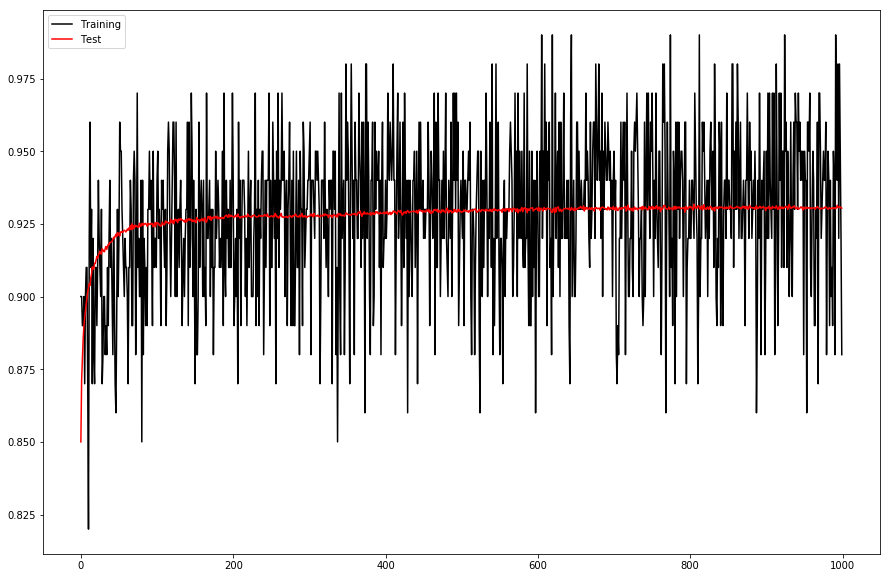

In [43]:
plt.plot(train_accs, 'k-', label='Training');
plt.plot(test_accs, 'r-', label='Test');
plt.legend(loc='best');